# LSTM using Time-based Features and Seasonal Statistics
## 6 from report

Anastasios Koutsogiannopoulos, 03321

Fani Banou, 03322

Ioannis Sakellariou, 03144

This program computes seasonal average features using only the training data. In other words, when we calculate the average close price for each hour, weekday, or month, we do it solely based on the training set. This approach prevents any leakage of future (test) information into the training process, ensuring that the model's evaluation remains fair and unbiased.

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Data Loading and Preprocessing Functions

In [ ]:
def mount_drive():
    """
    Mount Google Drive.
    """
    try:
        from google.colab import drive
        drive.mount('/content/drive/')
    except ImportError:
        print("Not running on Google Colab; skipping drive mount.")


In [ ]:
def load_dataset(file_path):
    """
    Load the dataset from the given CSV file, convert the 'unix' timestamp
    to datetime, set it as the index, and sort in ascending order.
    """
    data = pd.read_csv(file_path)
    data['date'] = pd.to_datetime(data['unix'], unit='s')
    data.set_index('date', inplace=True)
    data = data.sort_index(ascending=True)
    return data

In [ ]:
def resample_data(data):
    """
    Select only numeric columns and resample the dataset to hourly frequency
    using the mean of the values.
    """
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    data_hourly = numeric_data.resample('1h').mean()
    return data_hourly

In [ ]:
def add_time_features(df):
    """
    Create time-based features: hour, day, weekday, month, year,
    and a binary flag indicating if the day is a weekend.
    """
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
    return df

In [ ]:
def add_cyclic_features(df):
    """
    Add cyclic sine and cosine representations for hour, weekday, and month.
    """
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

In [ ]:
def select_final_features(df):
    """
    Select and reorder the columns to be used in further processing.
    """
    # Drop any rows with missing values
    df = df[['hour', 'weekday', 'month', 'hour_sin', 'hour_cos',
             'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos',
             'year', 'is_weekend', 'close']].dropna()
    return df

In [ ]:
def add_seasonal_stats_from_train(df, train_df, group_col, target_col):
    """
    Compute the mean of the target variable for each group based on group_col
    using only the training set, and map these values to the full dataset.
    """
    # Calculate group means from the training data
    train_seasonal_mean = train_df.groupby(group_col)[target_col].mean()
    # Map the calculated means to a new column in the full dataset
    df[f'{group_col}_mean_{target_col}'] = df[group_col].map(train_seasonal_mean)
    return df

### Data Splitting and Scaling Functions

In [ ]:
def split_data(df, train_end_date, test_start_date, test_end_date):
    """
    Split the dataset into training and testing sets based on provided date ranges.
    """
    train_data = df[:train_end_date]
    test_data = df[test_start_date:test_end_date]
    return train_data, test_data

In [ ]:
def scale_data(train_data, test_data):
    """
    Scale the training and testing data using MinMaxScaler.
    Returns scaled DataFrames preserving the original indices and column names.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    # Convert back to DataFrame with original indices and column names
    train_scaled = pd.DataFrame(train_scaled, columns=train_data.columns, index=train_data.index)
    test_scaled = pd.DataFrame(test_scaled, columns=test_data.columns, index=test_data.index)
    return train_scaled, test_scaled, scaler

### Window Creation Functions

In [ ]:
def create_windows(data, window_size, target_column_index):
    """
    Create sliding windows for features and target.
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        # Use all columns except the target column as features
        X.append(data[i:i + window_size, :-1])
        # Target is the value in the target column immediately after the window
        y.append(data[i + window_size, target_column_index])
    return np.array(X), np.array(y)

### Model Building, Training, and Evaluation Functions

In [ ]:
def build_model(input_shape):
    """
    Build and return a Sequential LSTM model for time series forecasting.
    The model consists of two LSTM layers with dropout and two Dense layers.
    """
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.4),
        LSTM(64, return_sequences=False),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dense(1)  # Single output for predicting 'close'
    ])
    return model

In [ ]:
def compile_and_train_model(model, X_train, y_train, learning_rate=0.001, batch_size=256, epochs=50, validation_split=0.2, patience=15):
    """
    Compile the model with Adam optimizer and MSE loss, then train it using early stopping.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                        validation_split=validation_split, verbose=1,
                        callbacks=[early_stopping], shuffle=False)
    return history

In [ ]:
def plot_loss(history):
    """
    Plot the training and validation loss curves.
    """
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Validation Loss')
    plt.show()

In [ ]:
def predict_and_evaluate(model, X_test, y_test, scaler, data_columns, target_column, test_start_date, test_end_date):
    """
    Use the trained model to predict on the test set, then inverse-transform
    the scaled predictions and true values. Finally, compute and print evaluation metrics,
    and plot the real vs predicted close prices.
    """
    # Predict on test set
    y_pred = model.predict(X_test)

    # Determine the number of columns except the target to create dummy columns for inverse_transform
    n_features = len(data_columns) - 1

    y_test_unscaled = scaler.inverse_transform(np.c_[np.zeros((y_test.shape[0], len(data_columns) - 1)), y_test])[:, -1]

    y_pred_unscaled = scaler.inverse_transform(np.c_[np.zeros((y_pred.shape[0], n_features)), y_pred])[:, -1]

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mse)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    # Create a date range for plotting
    dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')[:len(y_test_unscaled)]

    # Plot actual vs predicted close prices
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test_unscaled, label='Real Close Prices', alpha=0.75)
    plt.plot(dates, y_pred_unscaled, label='Predicted Close Prices', alpha=0.75)
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Real vs Predicted Close Prices')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def run_multiple_experiments(num_runs, X_train, y_train, X_test, y_test, scaler, data_columns, target_column, test_start_date, test_end_date):
    """
    Run the training and evaluation process multiple times num_runs, then average the evaluation
    metrics, loss curves, and predicted values.
    """
    training_histories = []
    mae_list = []
    rmse_list = []
    predictions = []
    train_times = []         # To store execution times for model training
    predict_times = []      # To store execution times for predict

    # Prepare the true values for evaluation by inverse transforming y_test
    n_features = len(data_columns) - 1
    y_test_unscaled = scaler.inverse_transform(np.c_[np.zeros((y_test.shape[0], n_features)), y_test.reshape(-1, 1)])[:, -1]

    for run in range(num_runs):
        print(f"Run {run+1}/{num_runs}")
        model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))

        start_time = time.time()
        history = compile_and_train_model(model, X_train, y_train)
        train_time = time.time() - start_time
        train_times.append(train_time)

        training_histories.append(history)

        start_time = time.time()
        y_pred = model.predict(X_test)
        predict_time = time.time() - start_time
        predict_times.append(predict_time)

        y_pred_unscaled = scaler.inverse_transform(
            np.c_[np.zeros((y_pred.shape[0], n_features)), y_pred]
        )[:, -1]
        predictions.append(y_pred_unscaled)

        mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
        rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
        mae_list.append(mae)
        rmse_list.append(rmse)
        print(f"Run {run+1} - MAE: {mae}, RMSE: {rmse}")

    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)
    print(f"\nAverage MAE over {num_runs} runs: {avg_mae}")
    print(f"Average RMSE over {num_runs} runs: {avg_rmse}")

    # Compute and print average execution times
    avg_train_time = np.mean(train_times)
    avg_predict_time = np.mean(predict_times)
    print(f"\nAverage Execution Times over {num_runs} Runs:")
    print(f"Model Training Time: {avg_train_time:.4f} seconds")
    print(f"Predicting Time: {avg_predict_time:.4f} seconds")

    # Average predictions
    avg_predictions = np.mean(np.array(predictions), axis=0)

    dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')[:len(avg_predictions)]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test_unscaled, label="Real Close Prices", color='blue', linestyle='dashed')
    plt.plot(dates, avg_predictions, label="Average Predicted Close Prices", color='red')
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title("Real vs Average Predicted Close Prices over Multiple Runs")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Average the loss curves over runs using the minimum epoch length across runs
    min_epochs = min(len(hist.history['loss']) for hist in training_histories)
    avg_loss = np.mean([hist.history['loss'][:min_epochs] for hist in training_histories], axis=0)
    avg_val_loss = np.mean([hist.history['val_loss'][:min_epochs] for hist in training_histories], axis=0)

    plt.figure(figsize=(10, 5))
    epochs_range = range(1, min_epochs+1)
    plt.plot(epochs_range, avg_loss, label="Average Training Loss")
    plt.plot(epochs_range, avg_val_loss, label="Average Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Average Loss Curves over {num_runs} Runs")
    plt.legend()
    plt.show()

### Main Function

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
X_train shape: (9864, 72, 11)
y_train shape: (9864,)
X_test shape: (240, 72, 11)
y_test shape: (240,)

Running multiple experiments...
Run 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0947 - mean_absolute_error: 0.2614 - val_loss: 0.1658 - val_mean_absolute_error: 0.3891
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1874 - mean_absolute_error: 0.3580 - val_loss: 0.0089 - val_mean_absolute_error: 0.0782
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0434 - mean_absolute_error: 0.1707 - val_loss: 0.0219 - val_mean_absolute_error: 0.1235
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0227 - mean_absolute_error: 0.1169 - val_loss: 0.0124 - val_mean_absolute_error: 0.0843
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0299 - mean_absolute_error: 0.1402 - val_loss: 0.0194 - val_mean_absolute_error: 0.1112
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0270 - mean_absolute_error: 0.1291 - val_loss: 0.0087 - val_mean_absolute_error: 0.0718
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0360 - mean_absolute_error: 0.1578 - val_loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0619 - mean_absolute_error: 0.2034 - val_loss: 0.1896 - val_mean_absolute_error: 0.4202
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1619 - mean_absolute_error: 0.3359 - val_loss: 0.0171 - val_mean_absolute_error: 0.1032
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0516 - mean_absolute_error: 0.1922 - val_loss: 0.0075 - val_mean_absolute_error: 0.0683
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0234 - mean_absolute_error: 0.1171 - val_loss: 0.0072 - val_mean_absolute_error: 0.0621
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0416 - mean_absolute_error: 0.1724 - val_loss: 0.0085 - val_mean_absolute_error: 0.0744
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0345 - mean_absolute_error: 0.1536 - val_loss: 0.0112 - val_mean_absolute_error: 0.0852
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0350 - mean_absolute_error: 0.1524 - val_loss: 0.0162 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0655 - mean_absolute_error: 0.2054 - val_loss: 0.1979 - val_mean_absolute_error: 0.4256
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1569 - mean_absolute_error: 0.3297 - val_loss: 0.0184 - val_mean_absolute_error: 0.1128
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0507 - mean_absolute_error: 0.1838 - val_loss: 0.0148 - val_mean_absolute_error: 0.0993
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0244 - mean_absolute_error: 0.1207 - val_loss: 0.0058 - val_mean_absolute_error: 0.0605
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0313 - mean_absolute_error: 0.1436 - val_loss: 0.0092 - val_mean_absolute_error: 0.0785
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0327 - mean_absolute_error: 0.1461 - val_loss: 0.0089 - val_mean_absolute_error: 0.0743
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0341 - mean_absolute_error: 0.1527 - val_loss: 0.0244 - 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Run 3 - MAE: 3427.666852346521, RMSE: 3631.278886979616
Run 4/10
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0533 - mean_absolute_error: 0.1886 - val_loss: 0.3377 - val_mean_absolute_error: 0.5704
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2190 - mean_absolute_error: 0.3930 - val_loss: 0.0259 - val_mean_absolute_error: 0.1416
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0633 - mean_absolute_error: 0.2083 - val_loss: 0.0178 - val_mean_absolute_error: 0.1028
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0227 - mean_absolute_error: 0.1160 - val_loss: 0.0075 - val_mean_absolute_error: 0.0713
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0371 - mean_absolute_error: 0.1617 - val_loss: 0.0153 - val_mean_absolute_error: 0.0978
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0234 - mean_absolute_error: 0.1176 - val_loss: 0.0079 - val_mean_absolute_error: 0.0675
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0328 - mean_absolute_error: 0.1485 - val_loss: 0.0105 - 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Run 4 - MAE: 5612.9360489016435, RMSE: 5800.664431547762
Run 5/10
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0621 - mean_absolute_error: 0.2035 - val_loss: 0.2956 - val_mean_absolute_error: 0.5353
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1894 - mean_absolute_error: 0.3604 - val_loss: 0.0108 - val_mean_absolute_error: 0.0854
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0497 - mean_absolute_error: 0.1844 - val_loss: 0.0231 - val_mean_absolute_error: 0.1254
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0244 - mean_absolute_error: 0.1220 - val_loss: 0.0156 - val_mean_absolute_error: 0.0979
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0290 - mean_absolute_error: 0.1350 - val_loss: 0.0184 - val_mean_absolute_error: 0.1080
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0371 - mean_absolute_error: 0.1546 - val_loss: 0.0242 - val_mean_absolute_error: 0.1227
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0348 - mean_absolute_error: 0.1476 - val_loss: 0.0079 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0573 - mean_absolute_error: 0.1975 - val_loss: 0.2137 - val_mean_absolute_error: 0.4487
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1813 - mean_absolute_error: 0.3570 - val_loss: 0.0137 - val_mean_absolute_error: 0.0920
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0418 - mean_absolute_error: 0.1664 - val_loss: 0.0287 - val_mean_absolute_error: 0.1514
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0282 - mean_absolute_error: 0.1285 - val_loss: 0.0072 - val_mean_absolute_error: 0.0661
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0313 - mean_absolute_error: 0.1438 - val_loss: 0.0111 - val_mean_absolute_error: 0.0866
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0349 - mean_absolute_error: 0.1504 - val_loss: 0.0082 - val_mean_absolute_error: 0.0731
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0440 - mean_absolute_error: 0.1752 - val_loss: 0.0131 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0661 - mean_absolute_error: 0.2106 - val_loss: 0.1165 - val_mean_absolute_error: 0.3273
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1316 - mean_absolute_error: 0.3066 - val_loss: 0.0205 - val_mean_absolute_error: 0.1212
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0363 - mean_absolute_error: 0.1570 - val_loss: 0.0086 - val_mean_absolute_error: 0.0726
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0231 - mean_absolute_error: 0.1188 - val_loss: 0.0073 - val_mean_absolute_error: 0.0670
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0285 - mean_absolute_error: 0.1326 - val_loss: 0.0084 - val_mean_absolute_error: 0.0722
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0290 - mean_absolute_error: 0.1357 - val_loss: 0.0138 - val_mean_absolute_error: 0.0911
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0363 - mean_absolute_error: 0.1588 - val_loss: 0.0230 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0537 - mean_absolute_error: 0.1874 - val_loss: 0.2489 - val_mean_absolute_error: 0.4868
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1739 - mean_absolute_error: 0.3490 - val_loss: 0.0333 - val_mean_absolute_error: 0.1659
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0495 - mean_absolute_error: 0.1835 - val_loss: 0.0085 - val_mean_absolute_error: 0.0724
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0218 - mean_absolute_error: 0.1151 - val_loss: 0.0076 - val_mean_absolute_error: 0.0658
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0290 - mean_absolute_error: 0.1344 - val_loss: 0.0111 - val_mean_absolute_error: 0.0816
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0297 - mean_absolute_error: 0.1381 - val_loss: 0.0256 - val_mean_absolute_error: 0.1272
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0371 - mean_absolute_error: 0.1629 - val_loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0683 - mean_absolute_error: 0.2167 - val_loss: 0.2675 - val_mean_absolute_error: 0.5029
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1948 - mean_absolute_error: 0.3700 - val_loss: 0.0244 - val_mean_absolute_error: 0.1376
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0535 - mean_absolute_error: 0.1884 - val_loss: 0.0313 - val_mean_absolute_error: 0.1582
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0319 - mean_absolute_error: 0.1356 - val_loss: 0.0060 - val_mean_absolute_error: 0.0625
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0327 - mean_absolute_error: 0.1498 - val_loss: 0.0139 - val_mean_absolute_error: 0.0987
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0347 - mean_absolute_error: 0.1479 - val_loss: 0.0094 - val_mean_absolute_error: 0.0789
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0385 - mean_absolute_error: 0.1566 - val_loss: 0.0230 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0707 - mean_absolute_error: 0.2186 - val_loss: 0.0445 - val_mean_absolute_error: 0.1897
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1136 - mean_absolute_error: 0.2872 - val_loss: 0.0084 - val_mean_absolute_error: 0.0722
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0333 - mean_absolute_error: 0.1498 - val_loss: 0.0431 - val_mean_absolute_error: 0.1886
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0401 - mean_absolute_error: 0.1571 - val_loss: 0.0074 - val_mean_absolute_error: 0.0704
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0535 - mean_absolute_error: 0.1933 - val_loss: 0.0130 - val_mean_absolute_error: 0.0958
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0368 - mean_absolute_error: 0.1567 - val_loss: 0.0111 - val_mean_absolute_error: 0.0820
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0458 - mean_absolute_error: 0.1763 - val_loss: 0.0435 - 

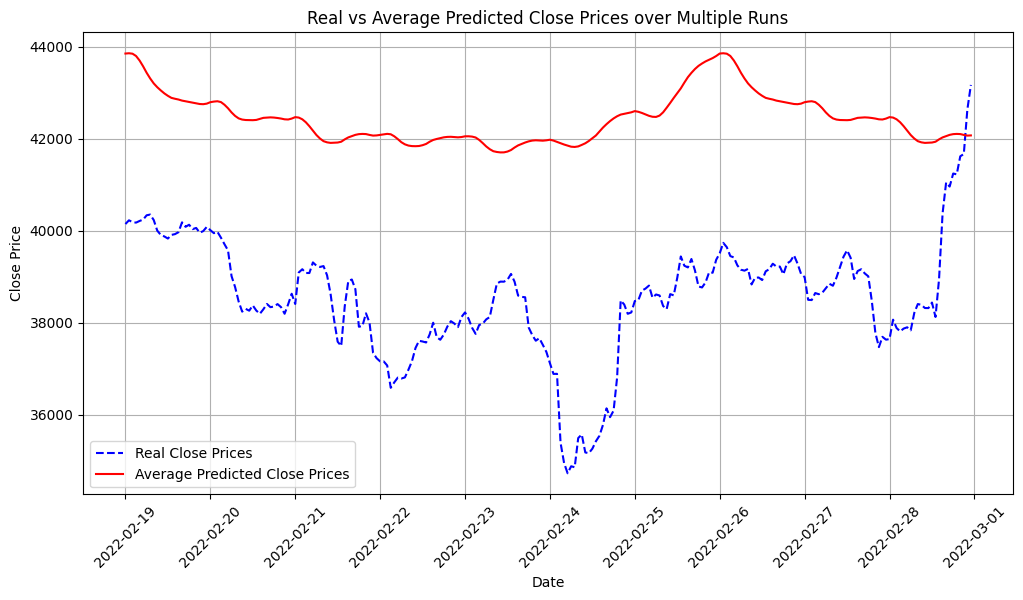

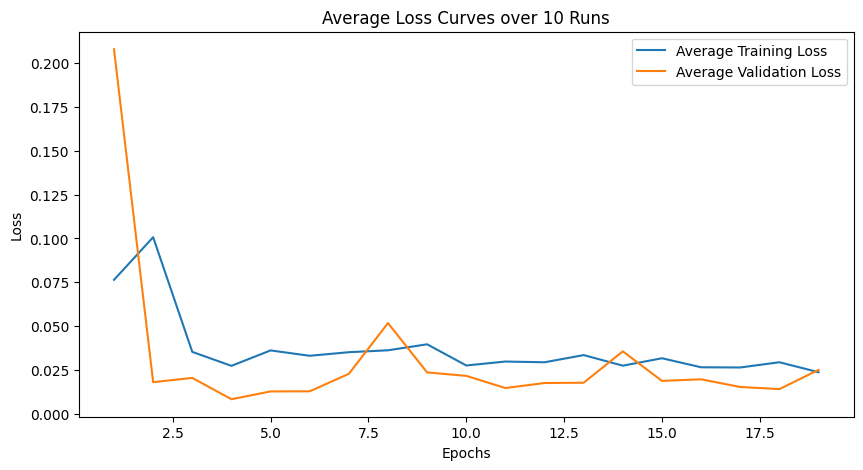

In [ ]:
def main():
    # Mount Google Drive
    mount_drive()

    # Define the file path for the dataset
    file_path = "/content/drive/MyDrive/bitcoin-dataset.csv"

    # Load and preprocess the dataset
    data = load_dataset(file_path)
    data_hourly = resample_data(data)

    # Add time-based features and cyclic features
    data_hourly = add_time_features(data_hourly)
    data_hourly = add_cyclic_features(data_hourly)

    # Select final columns for further processing
    data_hourly = select_final_features(data_hourly)

    # Define train/test date ranges
    train_end_date = '2022-02-18 23:59:59'
    test_start_date = '2022-02-19 00:00:00'
    test_end_date = '2022-02-28 23:59:59'

    # Split the data into training and testing sets
    train_data = data_hourly[:train_end_date]
    test_data = data_hourly[test_start_date:test_end_date]

    # Add seasonal statistics based only on the training set for 'hour', 'weekday', and 'month'
    data_hourly = add_seasonal_stats_from_train(data_hourly, train_data, 'hour', 'close')
    data_hourly = add_seasonal_stats_from_train(data_hourly, train_data, 'weekday', 'close')
    data_hourly = add_seasonal_stats_from_train(data_hourly, train_data, 'month', 'close')

    # For further processing, select only the desired columns including seasonal stats
    data_hourly = data_hourly[['hour_mean_close', 'weekday_mean_close', 'month_mean_close',
                               'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
                               'month_sin', 'month_cos', 'year', 'is_weekend', 'close']].dropna()

    # Re-split the data into training and testing sets using the updated dataframe
    train_data = data_hourly[:train_end_date]
    test_data = data_hourly[test_start_date:test_end_date]

    # Scale the data fit on train and transform test
    train_scaled, test_scaled, scaler = scale_data(train_data, test_data)

    # Create sliding windows
    window_size = 72
    target_column_index = data_hourly.columns.get_loc('close')

    X_train, y_train = create_windows(train_scaled.values, window_size, target_column_index)

    # For the test set, we combine the scaled train and test sets to create windows that cover the test period
    combined_data = pd.concat([train_scaled, test_scaled])
    X_test, y_test = create_windows(combined_data.values[-(len(test_scaled) + window_size):], window_size, target_column_index)

    # Print the shapes of the training and test windows
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    # # Build the LSTM model
    # input_shape = (X_train.shape[1], X_train.shape[2])
    # model = build_model(input_shape)
    # model.summary()

    # # Train the model
    # history = compile_and_train_model(model, X_train, y_train)

    # # Plot the training and validation loss curves
    # plot_loss(history)

    # # Evaluate the model on the test set and plot the predictions
    # predict_and_evaluate(model, X_test, y_test, scaler, data_hourly.columns, 'close', test_start_date, test_end_date)

    # --- Run the entire experiment multiple times (10 runs) ---
    print("\nRunning multiple experiments...")
    run_multiple_experiments(num_runs=10, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                             scaler=scaler, data_columns=data_hourly.columns, target_column='close',
                             test_start_date=test_start_date, test_end_date=test_end_date)

if __name__ == "__main__":
    main()